
# Installing external libs

In [0]:
!apt-get install openjdk-8-jdk-headless -qq > /dev/null
!wget -q https://www-us.apache.org/dist/spark/spark-2.4.5/spark-2.4.5-bin-hadoop2.7.tgz
!tar xf spark-2.4.5-bin-hadoop2.7.tgz
!pip install -q findspark

In [0]:
import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
os.environ["SPARK_HOME"] = "/content/spark-2.4.5-bin-hadoop2.7"

# Importing dataset

In [3]:
from google.colab import drive
drive.mount('/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /gdrive


In [0]:
import findspark
findspark.init()
from pyspark.sql import SparkSession
spark = SparkSession.builder.master("local[*]").config("spark.driver.memory", "10g").getOrCreate()

In [48]:
booksDF = spark.read.json('/gdrive/My Drive/UniOulu/BDPA/Dataset/books2.json')
booksDF.show()

+--------------------+--------------------+------------------+------+------------+--------------------+
|                 _id|             content|             genre|rating|rating_count|               title|
+--------------------+--------------------+------------------+------+------------+--------------------+
|[5eac7afeee1c2964...|The Project Guten...|    School Stories|  3.96|         125|   The White Feather|
|[5eac7afeee1c2964...|The Project Guten...|   Science Fiction|  4.02|         615|   The Sensitive Man|
|[5eac7b00ee1c2964...|The Project Guten...|Historical Fiction|  4.67|          39|                 463|
|[5eac7b00ee1c2964...|The Project Guten...|Children's Fiction|   1.0|           1|The Talking Leave...|
|[5eac7b00ee1c2964...|The Project Guten...|Children's Fiction|   1.0|           1|Through Forest an...|
|[5eac7b00ee1c2964...|The Project Guten...|   Science Fiction|  3.65|         246|            Sea Legs|
|[5eac7b01ee1c2964...|The Project Guten...|Children's Fiction|  

# Data preprocessing

In [0]:
def cut_gutenberg_statement(text):
    lines = text.splitlines()
    start_line = 0
    end_line = len(lines) - 1
    for i in range(len(lines)):
        if 'START OF THIS PROJECT GUTENBERG EBOOK' in lines[i]:
            start_line = i
            break
    for i in range(len(lines) - 1, 0, -1):
        if 'END OF THIS PROJECT GUTENBERG EBOOK' in lines[i]:
            end_line = i
            break
    return ' '.join(lines[start_line + 1: end_line])

In [0]:
def remove_punct_lower(text):
    PUNCT = '''!()-[]{};:'"\,<>./?@#$%^&*_~'''
    no_punct = ""
    for char in text:
        if char not in PUNCT:
            no_punct = no_punct + char
    return ' '.join(no_punct.split()).lower()   

In [0]:
from pyspark.sql.functions import udf
from pyspark.sql.types import *

# Cut the START OF GUTENBERG PROJECT and the END OF GUTENBERG PROJECT statement.
cut_gutenberg_statement_udf = udf(cut_gutenberg_statement, StringType())
booksDF = booksDF.withColumn('content_without_stat', cut_gutenberg_statement_udf('content'))
# Remove punctuation and lowercase text.
remove_punct_lower_udf = udf(remove_punct_lower, StringType())
booksDF = booksDF.withColumn('content_std', remove_punct_lower_udf('content_without_stat'))

In [50]:
# Remove content, content_without_stat and _id field.
booksDF = booksDF.drop(*['content_without_stat', 'content', '_id'])
booksDF.show()

+------------------+------+------------+--------------------+--------------------+
|             genre|rating|rating_count|               title|         content_std|
+------------------+------+------------+--------------------+--------------------+
|    School Stories|  3.96|         125|   The White Feather|produced by suzan...|
|   Science Fiction|  4.02|         615|   The Sensitive Man|produced by sanka...|
|Historical Fiction|  4.67|          39|                 463|produced by judit...|
|Children's Fiction|   1.0|           1|The Talking Leave...|this ebook is for...|
|Children's Fiction|   1.0|           1|Through Forest an...|produced by betha...|
|   Science Fiction|  3.65|         246|            Sea Legs|produced by greg ...|
|Children's Fiction|  4.12|          91|   The Young Buglers|produced by ted g...|
|   Science Fiction|  2.44|           9|When the Sleepers...|produced by sanka...|
|   Science Fiction|  4.25|           1|           The Sword|produced by greg ...|
|Chi

In [51]:
import pyspark.sql.functions as F

# Remove books with 0.0 or 1.0 ratings.
booksDF = booksDF.where((F.col('rating') != 1.0) & (F.col('rating') != 0.0))
booksDF.show()
booksDF.count()

+------------------+------+------------+--------------------+--------------------+
|             genre|rating|rating_count|               title|         content_std|
+------------------+------+------------+--------------------+--------------------+
|    School Stories|  3.96|         125|   The White Feather|produced by suzan...|
|   Science Fiction|  4.02|         615|   The Sensitive Man|produced by sanka...|
|Historical Fiction|  4.67|          39|                 463|produced by judit...|
|   Science Fiction|  3.65|         246|            Sea Legs|produced by greg ...|
|Children's Fiction|  4.12|          91|   The Young Buglers|produced by ted g...|
|   Science Fiction|  2.44|           9|When the Sleepers...|produced by sanka...|
|   Science Fiction|  4.25|           1|           The Sword|produced by greg ...|
|Children's Fiction|  4.23|          13|The Children's Pi...|produced by avina...|
|   Science Fiction|  3.45|          22|  The Helpful Robots|produced by greg ...|
|His

1839

In [52]:
# Calculate word count
booksDF = booksDF.withColumn('word_count', F.size(F.split(F.col('content_std'), ' ')))
booksDF.show()

+------------------+------+------------+--------------------+--------------------+----------+
|             genre|rating|rating_count|               title|         content_std|word_count|
+------------------+------+------------+--------------------+--------------------+----------+
|    School Stories|  3.96|         125|   The White Feather|produced by suzan...|     44679|
|   Science Fiction|  4.02|         615|   The Sensitive Man|produced by sanka...|     20847|
|Historical Fiction|  4.67|          39|                 463|produced by judit...|     46221|
|   Science Fiction|  3.65|         246|            Sea Legs|produced by greg ...|     13902|
|Children's Fiction|  4.12|          91|   The Young Buglers|produced by ted g...|    102661|
|   Science Fiction|  2.44|           9|When the Sleepers...|produced by sanka...|     11246|
|   Science Fiction|  4.25|           1|           The Sword|produced by greg ...|      3837|
|Children's Fiction|  4.23|          13|The Children's Pi...

In [0]:
# Remove books with word_count less than 1000.
booksDF = booksDF.where(F.col('word_count') >= 1000)

In [0]:
# Re assign genres.
booksDF = booksDF.withColumn('genre', F.when(F.col('genre') == 'Crime Fiction', 'Detective Fiction').otherwise(F.col('genre')))

In [0]:
booksDF = booksDF.withColumn('genre', F.when(F.col('genre') == 'Mystery Fiction', 'Fantasy').otherwise(F.col('genre')))

In [0]:
booksDF = booksDF.withColumn('genre', F.when(F.col('genre') == 'Gothic Fiction', 'Horror').otherwise(F.col('genre')))

In [0]:
booksDF = booksDF.withColumn('genre', F.when(F.col('genre') == 'Romantic Fiction', 'Movie Books').otherwise(F.col('genre')))

In [0]:
booksDF = booksDF.withColumn('genre', F.when(F.col('genre') == 'Adventure', 'Movie Books').otherwise(F.col('genre')))

In [0]:
booksDF = booksDF.withColumn('genre', F.when(F.col('genre') == 'General Fiction', 'Horror').otherwise(F.col('genre')))

In [0]:
booksDF = booksDF.withColumn('genre', F.when(F.col('genre') == 'Precursors of Science Fiction', 'School Stories').otherwise(F.col('genre')))

In [0]:
booksDF = booksDF.withColumn('genre', F.when((F.col('genre') == 'Science Fiction') & (F.col('word_count') < 35000), 'd_sf').otherwise(F.col('genre')))

In [62]:
booksDF.groupBy('genre').count().show()

+------------------+-----+
|             genre|count|
+------------------+-----+
|    Erotic Fiction|    9|
|              d_sf|  857|
|           Fantasy|   68|
|Children's Fiction|  192|
|    School Stories|   62|
|   Science Fiction|  179|
|            Horror|   50|
|           Western|   52|
| Detective Fiction|   65|
|Historical Fiction|  100|
|       Movie Books|   62|
|             Humor|   95|
+------------------+-----+



In [63]:
# Remove genres with too small amount of books.
booksDF = booksDF.where((F.col('genre') != 'Erotic Fiction') & (F.col('genre') != 'd_sf'))

booksDF.groupBy('genre').count().show()

+------------------+-----+
|             genre|count|
+------------------+-----+
|           Fantasy|   68|
|Children's Fiction|  192|
|    School Stories|   62|
|   Science Fiction|  179|
|            Horror|   50|
|           Western|   52|
| Detective Fiction|   65|
|Historical Fiction|  100|
|       Movie Books|   62|
|             Humor|   95|
+------------------+-----+



In [64]:
booksDF.count()

925

## Statistics

### Number of books from each genre

In [65]:
genre_count = booksDF.groupBy('genre').count().toPandas()
# Sort by count.
genre_count = genre_count.sort_values('count', ascending=False).reset_index()
genre_count

,index,genre,count
0,1,Children's Fiction,192
1,3,Science Fiction,179
2,7,Historical Fiction,100
3,9,Humor,95
4,0,Fantasy,68
5,6,Detective Fiction,65
6,2,School Stories,62
7,8,Movie Books,62
8,5,Western,52
9,4,Horror,50


In [0]:
import seaborn as sns
import matplotlib.pyplot as plt
sns.set(style='ticks', color_codes=True)
FIG_DIR = '/gdrive/My Drive/Inbox/Figures/'

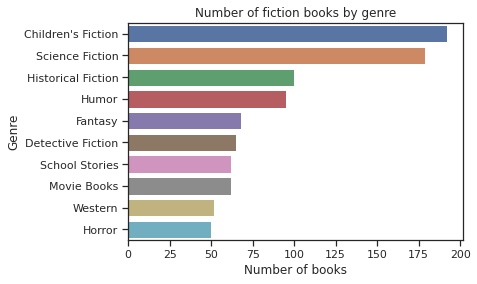

In [67]:
ax = sns.barplot(x='count', y='genre', data=genre_count)
ax.set(xlabel='Number of books', ylabel='Genre', title='Number of fiction books by genre')
plt.savefig(FIG_DIR + 'genre_count.png', bbox_inches='tight', dpi=300)
plt.show()

### Average number of words of books from each genre

In [68]:
booksDF.describe(['word_count']).show()

+-------+-----------------+
|summary|       word_count|
+-------+-----------------+
|  count|              925|
|   mean|67516.71135135135|
| stddev|38505.64276110467|
|    min|             1009|
|    max|           328989|
+-------+-----------------+



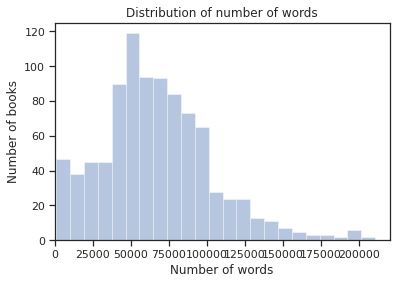

In [69]:
plt.xlim(0, 220000)
ax = sns.distplot(booksDF.select('word_count').toPandas(), kde=False)
ax.set(xlabel='Number of words', ylabel='Number of books', title='Distribution of number of words')
plt.savefig(FIG_DIR + 'word_count_dist.png', bbox_inches='tight', dpi=300)
plt.show()

In [70]:
genre_avg_word_count = booksDF.groupBy('genre').agg(F.mean('word_count')).toPandas()
genre_avg_word_count = genre_avg_word_count.sort_values('avg(word_count)', ascending=False).reset_index()
genre_avg_word_count

,index,genre,avg(word_count)
0,7,Historical Fiction,97724.980000
1,5,Western,76460.153846
2,8,Movie Books,75257.790323
3,1,Children's Fiction,71729.203125
4,4,Horror,63047.540000
5,3,Science Fiction,62846.877095
6,6,Detective Fiction,61218.246154
7,0,Fantasy,56322.808824
8,2,School Stories,55660.951613
9,9,Humor,48467.978947


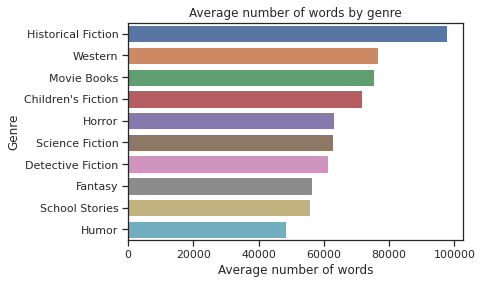

In [71]:
ax = sns.barplot(x='avg(word_count)', y='genre', data=genre_avg_word_count)
ax.set(xlabel='Average number of words', ylabel='Genre', title='Average number of words by genre')
plt.savefig(FIG_DIR + 'genre_avg_word_count.png', bbox_inches='tight', dpi=300)
plt.show()

### Average rating and rating_count of books from each genre

In [72]:
booksDF.describe(['rating', 'rating_count']).show()

+-------+------------------+------------------+
|summary|            rating|      rating_count|
+-------+------------------+------------------+
|  count|               925|               925|
|   mean|3.7319459459459465|            118.36|
| stddev|0.3935737818380711|211.96279976648847|
|    min|              1.33|                 1|
|    max|              4.86|               990|
+-------+------------------+------------------+



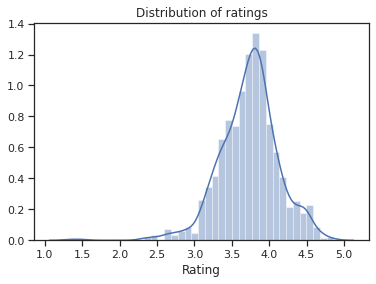

In [73]:
ax = sns.distplot(booksDF.select('rating').toPandas(), kde=True)
ax.set(xlabel='Rating', title='Distribution of ratings')
plt.savefig(FIG_DIR + 'rating_dist.png', bbox_inches='tight', dpi=300)
plt.show()

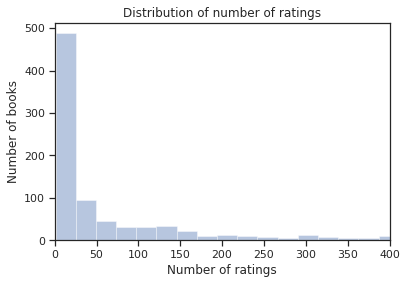

In [74]:
plt.xlim(0, 400)
ax = sns.distplot(booksDF.select('rating_count').toPandas(), kde=False)
ax.set(xlabel='Number of ratings', ylabel='Number of books', title='Distribution of number of ratings')
plt.savefig(FIG_DIR + 'rating_count_dist.png', bbox_inches='tight', dpi=300)
plt.show()

In [75]:
genre_avg_rating = booksDF.groupBy('genre').agg(F.avg('rating')).toPandas()
genre_avg_rating = genre_avg_rating.sort_values('avg(rating)', ascending=False).reset_index()
genre_avg_rating

,index,genre,avg(rating)
0,7,Historical Fiction,3.911700
1,8,Movie Books,3.820000
2,5,Western,3.818269
3,0,Fantasy,3.806324
4,2,School Stories,3.747742
5,4,Horror,3.727200
6,1,Children's Fiction,3.721771
7,9,Humor,3.715579
8,6,Detective Fiction,3.648923
9,3,Science Fiction,3.593296


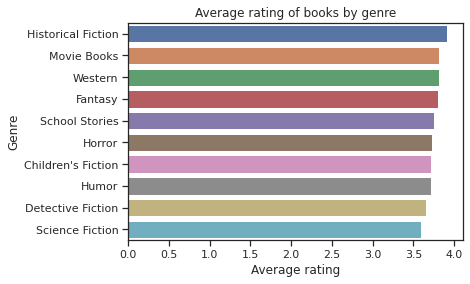

In [76]:
ax = sns.barplot(x='avg(rating)', y='genre', data=genre_avg_rating)
ax.set(xlabel='Average rating', ylabel='Genre', title='Average rating of books by genre')
plt.savefig(FIG_DIR + 'genre_avg_rating.png', bbox_inches='tight', dpi=300)
plt.show()

In [77]:
genre_avg_rating_count = booksDF.groupBy('genre').agg(F.avg('rating_count')).toPandas()
genre_avg_rating_count = genre_avg_rating_count.sort_values('avg(rating_count)', ascending=False).reset_index()
genre_avg_rating_count

,index,genre,avg(rating_count)
0,6,Detective Fiction,207.400000
1,5,Western,181.923077
2,0,Fantasy,158.602941
3,7,Historical Fiction,142.590000
4,9,Humor,126.273684
5,4,Horror,114.940000
6,3,Science Fiction,114.770950
7,2,School Stories,94.758065
8,1,Children's Fiction,74.229167
9,8,Movie Books,49.741935


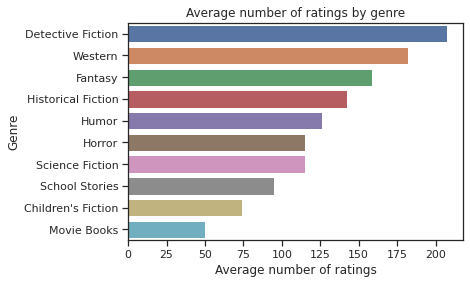

In [78]:
ax = sns.barplot(x='avg(rating_count)', y='genre', data=genre_avg_rating_count)
ax.set(xlabel='Average number of ratings', ylabel='Genre', title='Average number of ratings by genre')
plt.savefig(FIG_DIR + 'genre_avg_rating_count.png', bbox_inches='tight', dpi=300)
plt.show()

## Generating emotion swings

In [0]:
emotion_path = "/gdrive/My Drive/UniOulu/BDPA/Dataset/NRC-Emotion-Lexicon-Wordlevel.txt"
emotion_intensity_path = "/gdrive/My Drive/UniOulu/BDPA/Dataset/NRC-Emotion-Intensity-Lexicon.txt"
emotion_df = spark.read.format('csv').options(header='False', inferSchema='true', delimiter='\t').load(emotion_path)
emotion_intensity_df = spark.read.format('csv').options(header='True', inferSchema='true', delimiter='\t') .load(emotion_intensity_path)

In [80]:
emotion_df.show()
emotion_intensity_df.show()

+------+------------+---+
|   _c0|         _c1|_c2|
+------+------------+---+
| aback|       anger|  0|
| aback|anticipation|  0|
| aback|     disgust|  0|
| aback|        fear|  0|
| aback|         joy|  0|
| aback|    negative|  0|
| aback|    positive|  0|
| aback|     sadness|  0|
| aback|    surprise|  0|
| aback|       trust|  0|
|abacus|       anger|  0|
|abacus|anticipation|  0|
|abacus|     disgust|  0|
|abacus|        fear|  0|
|abacus|         joy|  0|
|abacus|    negative|  0|
|abacus|    positive|  0|
|abacus|     sadness|  0|
|abacus|    surprise|  0|
|abacus|       trust|  1|
+------+------------+---+
only showing top 20 rows

+------------+-------+-----------------------+
|        word|emotion|emotion-intensity-score|
+------------+-------+-----------------------+
|    outraged|  anger|                  0.964|
|   brutality|  anger|                  0.959|
|      hatred|  anger|                  0.953|
|     hateful|  anger|                   0.94|
|   terrorize|  anger

In [0]:
from collections import defaultdict
import json

# Generate emotion lexicon.
emotion_list = map(lambda row: row.asDict(), emotion_df.collect())
emotion_lex = defaultdict(list)
for emotion in emotion_list:
    if emotion['_c2'] == 1 and emotion['_c1'] != 'positive' and emotion['_c1'] != 'negative':
        emotion_lex[emotion['_c0']].append(emotion['_c1'])

# with open('emotion_lex.json', 'w') as json_file:
#     json.dump(emotion_lex, json_file)

In [0]:
# Generate emotion intensity dictionary
emotion_intensity_list = map(lambda row: row.asDict(), emotion_intensity_df.collect())
emotion_inten_dict = defaultdict(list)
for emotion_inten in emotion_intensity_list:
    emotion_inten_dict[emotion_inten['word']].append({emotion_inten['emotion']: emotion_inten['emotion-intensity-score']})

# with open('emotion_inten_dict.json', 'w') as json_file:
#     json.dump(emotion_inten_dict, json_file)

In [0]:
import math

def calc_percentage(vals):
    su = sum(vals)
    if su != 0:
        return [round(v / su, 4) for v in vals]
    else:
        return [0.0 for v in vals]

def calc_emo_vec(words):
    emo_vec = {'anger': 0, 'anticipation': 0, 'disgust': 0, 'fear': 0, 'joy': 0, 'sadness': 0, 'surprise': 0, 'trust': 0}
    for word in words:
        for emo in emotion_lex[word]:
            emo_vec[emo] += 1
    return calc_percentage(list(emo_vec.values()))

def calc_emo_inten(words):
    emo_vec = {'anger': 0.0, 'anticipation': 0.0, 'disgust': 0.0, 'fear': 0.0, 'joy': 0.0, 'sadness': 0.0, 'surprise': 0.0, 'trust': 0.0}
    for word in words:
        for emo in emotion_inten_dict[word]:
            emo_vec[list(emo.keys())[0]] += list(emo.values())[0]
    return calc_percentage(list(emo_vec.values()))

def chunks(lst, n):
    num = math.ceil(len(lst) / n)
    for i in range(0, len(lst), num):
        yield lst[i:i + num]

def gen_emo_vecs_chunks(text, num):
    words_list = text.split()
    emo_vecs = list()
    for words in list(chunks(words_list, num)):
        emo_vecs.append(calc_emo_vec(words))
    return emo_vecs

def gen_emo_inten_chunks(text, num):
    words_list = text.split()
    emo_vecs = list()
    for words in list(chunks(words_list, num)):
        emo_vecs.append(calc_emo_inten(words))
    return emo_vecs

def gen_emo_vecs_overall(text):
    words_list = text.split()
    return calc_emo_vec(words_list)

def gen_emo_inten_overall(text):
    words_list = text.split()
    return calc_emo_inten(words_list)

In [0]:
# Generate overall emotion vecor
gen_emo_vecs_overall_udf = udf(gen_emo_vecs_overall, ArrayType(FloatType()))
booksDF = booksDF.withColumn('emo_vecs_overall', gen_emo_vecs_overall_udf('content_std'))

In [0]:
# Generate emotion vector by chunks (10, 20, 30, 50)
booksDF = booksDF.withColumn('c10', F.lit(10))
booksDF = booksDF.withColumn('c20', F.lit(20))
booksDF = booksDF.withColumn('c30', F.lit(30))
booksDF = booksDF.withColumn('c50', F.lit(50))

gen_emo_vecs_chunks_udf = udf(gen_emo_vecs_chunks, ArrayType(ArrayType(FloatType())))
booksDF = booksDF.withColumn('emo_vecs_chunks_10', gen_emo_vecs_chunks_udf('content_std', 'c10'))
booksDF = booksDF.withColumn('emo_vecs_chunks_20', gen_emo_vecs_chunks_udf('content_std', 'c20'))
booksDF = booksDF.withColumn('emo_vecs_chunks_30', gen_emo_vecs_chunks_udf('content_std', 'c30'))
booksDF = booksDF.withColumn('emo_vecs_chunks_50', gen_emo_vecs_chunks_udf('content_std', 'c50'))

In [86]:
booksDF.show()

+------------------+------+------------+--------------------+--------------------+----------+--------------------+---+---+---+---+--------------------+--------------------+--------------------+--------------------+
|             genre|rating|rating_count|               title|         content_std|word_count|    emo_vecs_overall|c10|c20|c30|c50|  emo_vecs_chunks_10|  emo_vecs_chunks_20|  emo_vecs_chunks_30|  emo_vecs_chunks_50|
+------------------+------+------------+--------------------+--------------------+----------+--------------------+---+---+---+---+--------------------+--------------------+--------------------+--------------------+
|    School Stories|  3.96|         125|   The White Feather|produced by suzan...|     44679|[0.1147, 0.1775, ...| 10| 20| 30| 50|[[0.0771, 0.1849,...|[[0.0852, 0.1738,...|[[0.0794, 0.1869,...|[[0.0826, 0.1983,...|
|Historical Fiction|  4.67|          39|                 463|produced by judit...|     46221|[0.1623, 0.1398, ...| 10| 20| 30| 50|[[0.142, 0

In [0]:
# Generate overall emotion intensity
gen_emo_inten_overall_udf = udf(gen_emo_inten_overall, ArrayType(FloatType()))
booksDF = booksDF.withColumn('emo_inten_overall', gen_emo_inten_overall_udf('content_std'))

# Generate emotion intensity by chunks (10, 15, 20)
gen_emo_inten_chunks_udf = udf(gen_emo_inten_chunks, ArrayType(ArrayType(FloatType())))
booksDF = booksDF.withColumn('emo_inten_chunks_10', gen_emo_inten_chunks_udf('content_std', 'c10'))
booksDF = booksDF.withColumn('emo_inten_chunks_20', gen_emo_inten_chunks_udf('content_std', 'c20'))
booksDF = booksDF.withColumn('emo_inten_chunks_30', gen_emo_inten_chunks_udf('content_std', 'c30'))
booksDF = booksDF.withColumn('emo_inten_chunks_50', gen_emo_inten_chunks_udf('content_std', 'c50'))

In [88]:
booksDF.show()

+------------------+------+------------+--------------------+--------------------+----------+--------------------+---+---+---+---+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+
|             genre|rating|rating_count|               title|         content_std|word_count|    emo_vecs_overall|c10|c20|c30|c50|  emo_vecs_chunks_10|  emo_vecs_chunks_20|  emo_vecs_chunks_30|  emo_vecs_chunks_50|   emo_inten_overall| emo_inten_chunks_10| emo_inten_chunks_20| emo_inten_chunks_30| emo_inten_chunks_50|
+------------------+------+------------+--------------------+--------------------+----------+--------------------+---+---+---+---+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+
|    School Stories|  3.96|         125|

## Exporting emotion vectors

In [0]:
import pandas as pd

def std_emo_overall(emo_overall_list, column_str):
    emo_overall_csv = list()
    for line in emo_overall_list:
        dd = defaultdict()
        dd['title'] = line['title']
        dd['genre'] = line['genre']
        dd['rating'] = line['rating']
        dd['rating_count'] = line['rating_count']
        for i, e in enumerate(['anger', 'anticipation', 'disgust', 'fear', 'joy', 'sadness', 'surprise', 'trust']):
            dd[e] = line[column_str][i]
        emo_overall_csv.append(dd)
    return emo_overall_csv

def std_emo_chunks(emo_chunks_list, column_str):
    emo_chunks_csv = list()
    for line in emo_chunks_list:
        dd = defaultdict()
        dd['title'] = line['title']
        dd['genre'] = line['genre']
        dd['rating'] = line['rating']
        dd['rating_count'] = line['rating_count']
        for i, emos in enumerate(line[column_str]):
            for j, e in enumerate(['anger', 'anticipation', 'disgust', 'fear', 'joy', 'sadness', 'surprise', 'trust']):
                dd[e+'_'+str(i)] = emos[j]
        emo_chunks_csv.append(dd)
    return emo_chunks_csv

In [0]:
# Save emotion vectors and intensity overall
emo_vecs_overall_df = booksDF.select(*['title', 'genre', 'rating', 'rating_count', 'emo_vecs_overall'])
emo_vecs_overall_list = list(map(lambda row: row.asDict(), emo_vecs_overall_df.collect()))
emo_vecs_overall_csv = std_emo_overall(emo_vecs_overall_list, 'emo_vecs_overall')
emo_overall_df = pd.DataFrame(emo_vecs_overall_csv)

emo_inten_overall_df = booksDF.select(*['title', 'genre', 'rating', 'rating_count', 'emo_inten_overall'])
emo_inten_overall_list = list(map(lambda row: row.asDict(), emo_inten_overall_df.collect()))
emo_inten_overall_csv = std_emo_overall(emo_inten_overall_list, 'emo_inten_overall')
inten_overall_df = pd.DataFrame(emo_inten_overall_csv)

In [0]:
# Save emotion vectors and intensity chunks (10, 15, 20)
emo_vecs_chunks_10_df = booksDF.select(*['title', 'genre', 'rating', 'rating_count', 'emo_vecs_chunks_10'])
emo_vecs_chunks_10_list = list(map(lambda row: row.asDict(), emo_vecs_chunks_10_df.collect()))
emo_vecs_chunks_10_csv = std_emo_chunks(emo_vecs_chunks_10_list, 'emo_vecs_chunks_10')
emo_10_df = pd.DataFrame(emo_vecs_chunks_10_csv)

emo_vecs_chunks_20_df = booksDF.select(*['title', 'genre', 'rating', 'rating_count', 'emo_vecs_chunks_20'])
emo_vecs_chunks_20_list = list(map(lambda row: row.asDict(), emo_vecs_chunks_20_df.collect()))
emo_vecs_chunks_30_df = booksDF.select(*['title', 'genre', 'rating', 'rating_count', 'emo_vecs_chunks_30'])
emo_vecs_chunks_30_list = list(map(lambda row: row.asDict(), emo_vecs_chunks_30_df.collect()))
emo_vecs_chunks_20_csv = std_emo_chunks(emo_vecs_chunks_20_list, 'emo_vecs_chunks_20')
emo_vecs_chunks_30_csv = std_emo_chunks(emo_vecs_chunks_30_list, 'emo_vecs_chunks_30')
emo_20_df = pd.DataFrame(emo_vecs_chunks_20_csv)
emo_30_df = pd.DataFrame(emo_vecs_chunks_30_csv)

emo_vecs_chunks_50_df = booksDF.select(*['title', 'genre', 'rating', 'rating_count', 'emo_vecs_chunks_50'])
emo_vecs_chunks_50_list = list(map(lambda row: row.asDict(), emo_vecs_chunks_50_df.collect()))
emo_vecs_chunks_50_csv = std_emo_chunks(emo_vecs_chunks_50_list, 'emo_vecs_chunks_50')
emo_50_df = pd.DataFrame(emo_vecs_chunks_50_csv)

emo_inten_chunks_10_df = booksDF.select(*['title', 'genre', 'rating', 'rating_count', 'emo_inten_chunks_10'])
emo_inten_chunks_10_list = list(map(lambda row: row.asDict(), emo_inten_chunks_10_df.collect()))
emo_inten_chunks_10_csv = std_emo_chunks(emo_inten_chunks_10_list, 'emo_inten_chunks_10')
inten_10_df = pd.DataFrame(emo_inten_chunks_10_csv)

emo_inten_chunks_20_df = booksDF.select(*['title', 'genre', 'rating', 'rating_count', 'emo_inten_chunks_20'])
emo_inten_chunks_20_list = list(map(lambda row: row.asDict(), emo_inten_chunks_20_df.collect()))
emo_inten_chunks_30_df = booksDF.select(*['title', 'genre', 'rating', 'rating_count', 'emo_inten_chunks_30'])
emo_inten_chunks_30_list = list(map(lambda row: row.asDict(), emo_inten_chunks_30_df.collect()))
emo_inten_chunks_20_csv = std_emo_chunks(emo_inten_chunks_20_list, 'emo_inten_chunks_20')
emo_inten_chunks_30_csv = std_emo_chunks(emo_inten_chunks_30_list, 'emo_inten_chunks_30')
inten_20_df = pd.DataFrame(emo_inten_chunks_20_csv)
inten_30_df = pd.DataFrame(emo_inten_chunks_30_csv)

emo_inten_chunks_50_df = booksDF.select(*['title', 'genre', 'rating', 'rating_count', 'emo_inten_chunks_50'])
emo_inten_chunks_50_list = list(map(lambda row: row.asDict(), emo_inten_chunks_50_df.collect()))
emo_inten_chunks_50_csv = std_emo_chunks(emo_inten_chunks_50_list, 'emo_inten_chunks_50')
inten_50_df = pd.DataFrame(emo_inten_chunks_50_csv)

In [0]:
with open('/gdrive/My Drive/Inbox/Datasets/emo_vec_overall.csv', 'w') as f:
    emo_overall_df.to_csv(f)

with open('/gdrive/My Drive/Inbox/Datasets/emo_inten_overall.csv', 'w') as f:
    inten_overall_df.to_csv(f)

with open('/gdrive/My Drive/Inbox/Datasets/emo_vec_10.csv', 'w') as f:
    emo_10_df.to_csv(f)

with open('/gdrive/My Drive/Inbox/Datasets/emo_vec_20.csv', 'w') as f:
    emo_20_df.to_csv(f)

with open('/gdrive/My Drive/Inbox/Datasets/emo_vec_30.csv', 'w') as f:
    emo_30_df.to_csv(f)

with open('/gdrive/My Drive/Inbox/Datasets/emo_vec_50.csv', 'w') as f:
    emo_50_df.to_csv(f)

with open('/gdrive/My Drive/Inbox/Datasets/emo_inten_10.csv', 'w') as f:
    inten_10_df.to_csv(f)

with open('/gdrive/My Drive/Inbox/Datasets/emo_inten_20.csv', 'w') as f:
    inten_20_df.to_csv(f)

with open('/gdrive/My Drive/Inbox/Datasets/emo_inten_30.csv', 'w') as f:
    inten_30_df.to_csv(f)

with open('/gdrive/My Drive/Inbox/Datasets/emo_inten_50.csv', 'w') as f:
    inten_50_df.to_csv(f)

In [93]:
genre_content_df = booksDF.select(*['title', 'genre', 'rating', 'rating_count', 'content_std', 'word_count']).toPandas()
genre_content_df.head()

,title,genre,rating,rating_count,content_std,word_count
0,The White Feather,School Stories,3.96,125,produced by suzanne l shell charles franks and...,44679
1,463,Historical Fiction,4.67,39,produced by judith boss html version by al hai...,46221
2,The Young Buglers,Children's Fiction,4.12,91,produced by ted garvin suzanne shell william f...,102661
3,The Children's Pilgrimage,Children's Fiction,4.23,13,produced by avinash kothare tom allen charles ...,83173
4,A Houseful of Girls,Children's Fiction,3.33,12,produced by jonathan ingram jacqueline jeremy ...,92847


In [0]:
with open('/gdrive/My Drive/Inbox/Datasets/books_gutenberg.csv', 'w') as f:
    genre_content_df.to_csv(f)

## Emotion traces visualization

In [95]:
emo_20_df.head()

,title,genre,rating,rating_count,anger_0,anticipation_0,disgust_0,fear_0,joy_0,sadness_0,surprise_0,trust_0,anger_1,anticipation_1,disgust_1,fear_1,joy_1,sadness_1,surprise_1,trust_1,anger_2,anticipation_2,disgust_2,fear_2,joy_2,sadness_2,surprise_2,trust_2,anger_3,anticipation_3,disgust_3,fear_3,joy_3,sadness_3,surprise_3,trust_3,anger_4,anticipation_4,disgust_4,fear_4,...,anger_15,anticipation_15,disgust_15,fear_15,joy_15,sadness_15,surprise_15,trust_15,anger_16,anticipation_16,disgust_16,fear_16,joy_16,sadness_16,surprise_16,trust_16,anger_17,anticipation_17,disgust_17,fear_17,joy_17,sadness_17,surprise_17,trust_17,anger_18,anticipation_18,disgust_18,fear_18,joy_18,sadness_18,surprise_18,trust_18,anger_19,anticipation_19,disgust_19,fear_19,joy_19,sadness_19,surprise_19,trust_19
0,The White Feather,School Stories,3.96,125,0.0852,0.1738,0.0623,0.1148,0.1311,0.1049,0.0852,0.2426,0.0681,0.1971,0.0717,0.1254,0.1505,0.1004,0.0860,0.2007,0.1154,0.1603,0.0833,0.1314,0.0929,0.1506,0.0897,0.1763,0.1375,0.1844,0.0656,0.1250,0.1125,0.1062,0.1156,0.1531,0.1157,0.1455,0.0746,0.1455,...,0.1180,0.1740,0.0531,0.1239,0.1062,0.1209,0.1150,0.1888,0.1382,0.1794,0.0706,0.1265,0.1029,0.1029,0.0882,0.1912,0.1312,0.1720,0.0496,0.1283,0.0962,0.0787,0.1020,0.2420,0.1402,0.1433,0.0717,0.1495,0.0966,0.1246,0.0810,0.1931,0.0705,0.1630,0.0661,0.1542,0.1101,0.1145,0.0749,0.2467
1,463,Historical Fiction,4.67,39,0.1184,0.2015,0.0630,0.1108,0.1436,0.1184,0.0856,0.1587,0.1615,0.1677,0.0476,0.1760,0.1118,0.1118,0.0932,0.1304,0.1559,0.1492,0.0579,0.1804,0.1114,0.1403,0.1047,0.1002,0.1507,0.1659,0.0546,0.1834,0.1157,0.0895,0.1266,0.1135,0.1854,0.1373,0.0778,0.2082,...,0.1682,0.1267,0.0829,0.2051,0.0922,0.0922,0.1014,0.1313,0.1721,0.1319,0.0746,0.2065,0.0994,0.1128,0.0880,0.1147,0.1477,0.1371,0.0844,0.1498,0.1160,0.0886,0.0949,0.1814,0.1780,0.1212,0.0814,0.2197,0.0739,0.1402,0.1004,0.0852,0.1441,0.1242,0.0776,0.1863,0.1153,0.1574,0.0953,0.0998
2,The Young Buglers,Children's Fiction,4.12,91,0.1135,0.1501,0.0504,0.1412,0.0996,0.1236,0.1009,0.2207,0.1069,0.1530,0.0541,0.1464,0.1148,0.1082,0.1003,0.2164,0.0944,0.1751,0.0616,0.1272,0.1204,0.1135,0.1053,0.2025,0.0950,0.1869,0.0549,0.1157,0.1202,0.0786,0.0979,0.2507,0.0810,0.1861,0.0312,0.1193,...,0.2047,0.0980,0.0831,0.2419,0.0347,0.1625,0.0670,0.1079,0.1166,0.1406,0.0703,0.1693,0.0799,0.1454,0.0751,0.2029,0.0876,0.1782,0.0722,0.1536,0.1014,0.1137,0.0998,0.1935,0.1443,0.1118,0.0676,0.2185,0.0793,0.1443,0.0780,0.1560,0.1580,0.1163,0.0747,0.1740,0.0832,0.1249,0.0726,0.1964
3,The Children's Pilgrimage,Children's Fiction,4.23,13,0.0694,0.1730,0.0682,0.0997,0.1894,0.1364,0.0644,0.1995,0.0993,0.2065,0.0601,0.0993,0.1673,0.1124,0.0837,0.1712,0.0885,0.1836,0.0612,0.0924,0.2070,0.1146,0.0651,0.1875,0.1168,0.1703,0.1003,0.1113,0.1511,0.1071,0.0701,0.1731,0.1060,0.1902,0.0734,0.1101,...,0.0738,0.1943,0.0602,0.0949,0.1687,0.1611,0.0798,0.1672,0.0952,0.1891,0.0742,0.1289,0.1261,0.1793,0.0560,0.1513,0.1086,0.1470,0.0927,0.1152,0.1457,0.1563,0.0728,0.1616,0.0804,0.1746,0.0590,0.0829,0.1897,0.1658,0.0867,0.1608,0.0784,0.1658,0.0797,0.0951,0.1954,0.1221,0.0835,0.1799
4,A Houseful of Girls,Children's Fiction,3.33,12,0.0636,0.1767,0.0403,0.0729,0.1752,0.1039,0.1039,0.2636,0.0965,0.1649,0.0670,0.1287,0.1488,0.1314,0.0697,0.1930,0.0957,0.1599,0.0677,0.1354,0.1179,0.1389,0.0665,0.2182,0.0791,0.1759,0.0465,0.0930,0.1558,0.1457,0.0641,0.2399,0.0678,0.1794,0.0607,0.0904,...,0.0950,0.1508,0.0628,0.1397,0.1215,0.1480,0.0754,0.2067,0.0752,0.1805,0.0541,0.1083,0.1714,0.1068,0.0917,0.2120,0.0955,0.1658,0.0531,0.1247,0.1432,0.1366,0.0769,0.2042,0.0742,0.1826,0.0485,0.1098,0.1484,0.1270,0.0884,0.2211,0.0824,0.1828,0.0463,0.0875,0.1892,0.1042,0.0965,0.2111


In [0]:
emo_20_visual = emo_20_df.drop(['title', 'rating', 'rating_count'], axis=1)
genre_avg_emo_20 = emo_20_visual.groupby('genre').mean()

In [97]:
genre_avg_emo_20

,anger_0,anticipation_0,disgust_0,fear_0,joy_0,sadness_0,surprise_0,trust_0,anger_1,anticipation_1,disgust_1,fear_1,joy_1,sadness_1,surprise_1,trust_1,anger_2,anticipation_2,disgust_2,fear_2,joy_2,sadness_2,surprise_2,trust_2,anger_3,anticipation_3,disgust_3,fear_3,joy_3,sadness_3,surprise_3,trust_3,anger_4,anticipation_4,disgust_4,fear_4,joy_4,sadness_4,surprise_4,trust_4,...,anger_15,anticipation_15,disgust_15,fear_15,joy_15,sadness_15,surprise_15,trust_15,anger_16,anticipation_16,disgust_16,fear_16,joy_16,sadness_16,surprise_16,trust_16,anger_17,anticipation_17,disgust_17,fear_17,joy_17,sadness_17,surprise_17,trust_17,anger_18,anticipation_18,disgust_18,fear_18,joy_18,sadness_18,surprise_18,trust_18,anger_19,anticipation_19,disgust_19,fear_19,joy_19,sadness_19,surprise_19,trust_19
genre,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
Children's Fiction,0.091695,0.175381,0.064006,0.121495,0.145346,0.107699,0.087978,0.206401,0.100333,0.174235,0.064016,0.131607,0.135801,0.112808,0.086385,0.194815,0.097770,0.172339,0.066860,0.130102,0.137323,0.113457,0.089408,0.192740,0.100530,0.172329,0.063570,0.132032,0.135221,0.113790,0.089377,0.193157,0.100171,0.170010,0.064364,0.133771,0.137356,0.113565,0.088967,0.191793,...,0.103665,0.169089,0.062854,0.138977,0.130776,0.114914,0.086301,0.193419,0.103801,0.168974,0.063797,0.137520,0.132417,0.113728,0.086268,0.188283,0.105189,0.172934,0.061589,0.137453,0.131602,0.112940,0.086226,0.192053,0.107687,0.167115,0.063201,0.137033,0.130865,0.112748,0.085534,0.195815,0.093545,0.171805,0.057946,0.113460,0.145401,0.106010,0.081530,0.225100
Detective Fiction,0.095142,0.158178,0.068455,0.143732,0.112242,0.128485,0.089583,0.204163,0.093006,0.158542,0.071338,0.144968,0.107363,0.125209,0.090278,0.209309,0.096462,0.150514,0.072846,0.144417,0.113138,0.121072,0.085094,0.216454,0.098538,0.158418,0.070583,0.143326,0.111214,0.125615,0.084438,0.207831,0.101014,0.145512,0.074302,0.144932,0.107309,0.121486,0.082742,0.222712,...,0.103402,0.150957,0.070252,0.151966,0.105765,0.126577,0.080395,0.210668,0.104725,0.151866,0.073389,0.149014,0.101671,0.131640,0.080702,0.206989,0.109822,0.142052,0.071231,0.152988,0.108458,0.129015,0.084857,0.201565,0.110405,0.143574,0.073511,0.160674,0.101058,0.131178,0.081945,0.197655,0.107225,0.151734,0.068006,0.148320,0.108275,0.126742,0.082625,0.207068
Fantasy,0.087750,0.174162,0.071969,0.120546,0.154957,0.103010,0.086203,0.201391,0.094749,0.162522,0.079019,0.127172,0.147718,0.111759,0.081454,0.195606,0.093860,0.159519,0.077722,0.131041,0.146388,0.114393,0.087999,0.189091,0.091097,0.169537,0.080343,0.125265,0.146232,0.117397,0.083434,0.186690,0.095196,0.157475,0.072431,0.131941,0.148488,0.119763,0.082528,0.192163,...,0.097010,0.155565,0.082644,0.139262,0.141297,0.117507,0.077434,0.189259,0.097651,0.159446,0.074840,0.137831,0.143394,0.119232,0.083079,0.184537,0.101894,0.161949,0.072974,0.134809,0.140059,0.117056,0.082194,0.189062,0.094509,0.162837,0.070481,0.125816,0.150688,0.107372,0.083490,0.204791,0.098069,0.156391,0.076403,0.116094,0.141479,0.110050,0.076425,0.225085
Historical Fiction,0.096728,0.165316,0.064508,0.129025,0.129841,0.116382,0.073783,0.224411,0.104740,0.148840,0.064790,0.147643,0.125055,0.119839,0.079320,0.199775,0.101073,0.157068,0.067376,0.141335,0.123178,0.114987,0.079177,0.195790,0.099917,0.152951,0.066719,0.144380,0.121425,0.119437,0.083279,0.191888,0.108755,0.151822,0.067536,0.145018,0.117337,0.119457,0.077428,0.192638,...,0.110495,0.143178,0.068828,0.155115,0.115979,0.124786,0.075210,0.196425,0.109115,0.149068,0.069863,0.151478,0.120156,0.120247,0.072573,0.197495,0.109522,0.142285,0.068884,0.150241,0.122228,0.123531,0.071939,0.201363,0.105007,0.148501,0.066086,0.151866,0.114978,0.123540,0.075480,0.194543,0.103148,0.175219,0.058821,0.124013,0.120834,0.113375,0.073508,0.231078
Horror,0.097316,0.158896,0.064274,0.126742,0.132758,0.135448,0.075812,0.208748,0.114788,0.150888,0.076464,0.135348,0.123914,0.143630,0.080970,0.174006,0.12427

In [0]:
def gen_fig_df(df, genre_str):
    fig_dict = {'anger': list(), 'anticipation': list(), 'disgust': list(), 'fear': list(), 'joy': list(), 'sadness': list(), 'surprise': list(), 'trust': list()}
    genre = df.loc[genre_str]
    for i in range(0, len(genre), 8):
        for k, j in zip(fig_dict.keys(), range(8)):
            fig_dict[k].append(genre[i+j])
    return pd.DataFrame(fig_dict)

In [0]:
def draw_et(df, title_str):
    ax = sns.lineplot(data=df, dashes=False)
    ax.set_xticks(range(20))
    ax.set(xlabel='Chunks', ylabel='Average emotion weight', title='Emotion Trace of ' + title_str)
    plt.legend(framealpha=0.6)
    plt.savefig(FIG_DIR + title_str.lower() + '_et_20.png', bbox_inches='tight', dpi=300)
    plt.show()

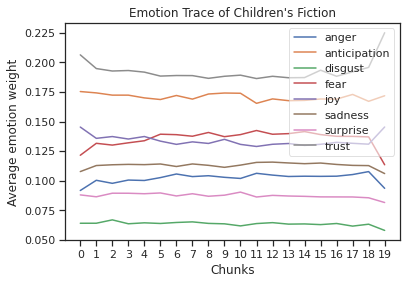

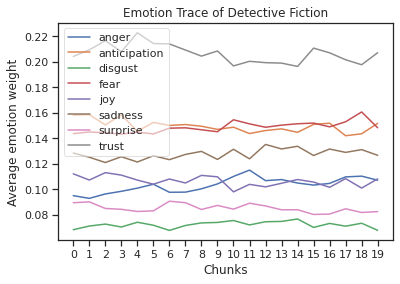

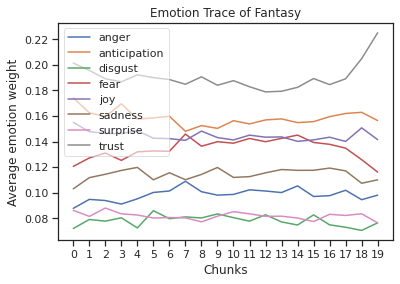

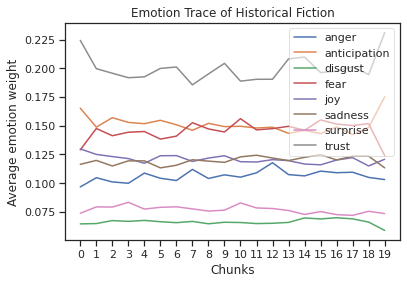

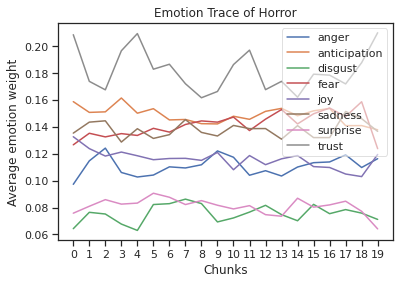

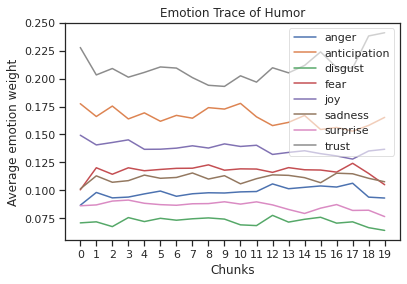

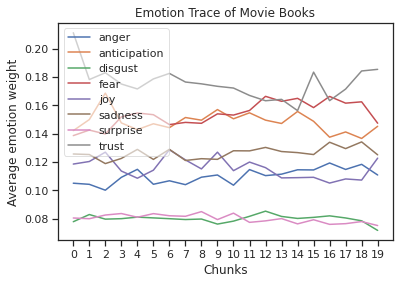

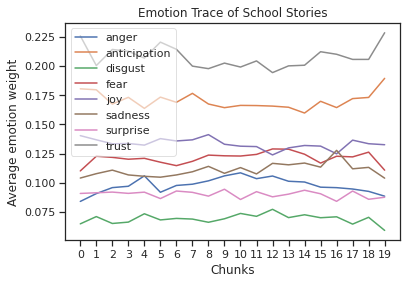

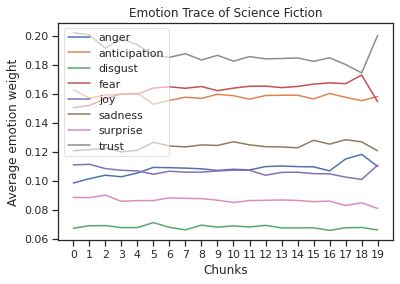

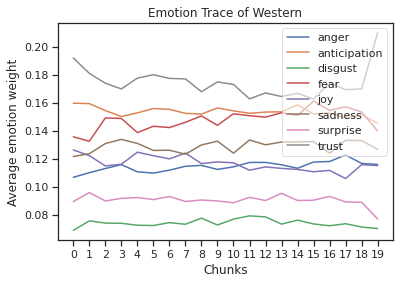

In [100]:
genre_list = ["Children's Fiction", 'Detective Fiction', 'Fantasy', 'Historical Fiction', 'Horror',
              'Humor', 'Movie Books', 'School Stories', 'Science Fiction', 'Western']
for g in genre_list:
    draw_et(gen_fig_df(genre_avg_emo_20, g), g)

## Popular fiction vs the rest

In [0]:
import pandas as pd
import numpy as np

In [0]:
emo_20_df = pd.read_csv('/gdrive/My Drive/Inbox/Datasets/emo_vec_20.csv', index_col=[0])

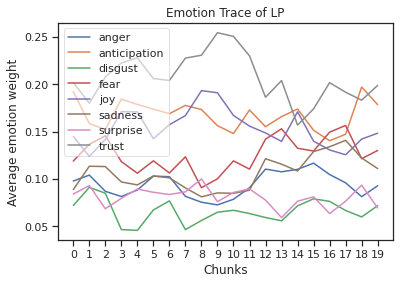

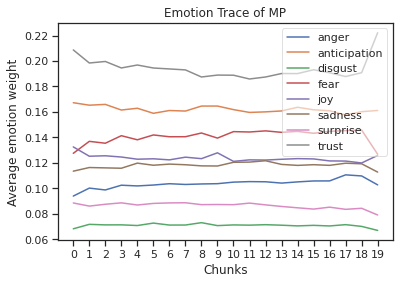

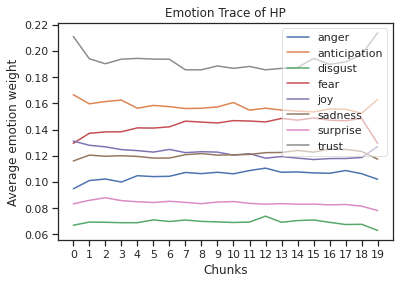

In [105]:
emo_20_rating = emo_20_df.drop(['title', 'genre', 'rating_count'], axis=1)

bins = [0, 2, 4, 5]
rating_level_df = emo_20_rating.groupby(pd.cut(emo_20_rating['rating'], 3, labels=['LP', 'MP', 'HP'])).mean().drop(['rating'], axis=1)

overall_list = list()
for g in ['LP', 'MP', 'HP']:
    visual_df = gen_fig_df(rating_level_df, g)
    dev_one_emotion = np.mean(visual_df.std(axis=0))
    dev_emo_dist = np.mean(visual_df.std(axis=1))
    overall_list.append({g: [dev_one_emotion, dev_emo_dist]})
    draw_et(visual_df, g)

In [106]:
print(overall_list)

[{'LP': [0.01650382781401399, 0.0500714921771158]}, {'MP': [0.0035957221175756714, 0.04038259217990328]}, {'HP': [0.003912855975995165, 0.04015436666091894]}]


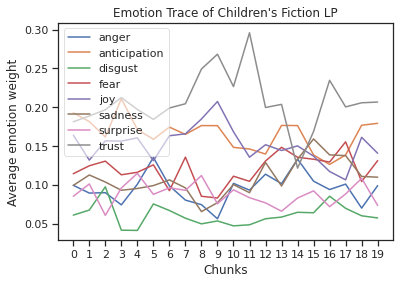

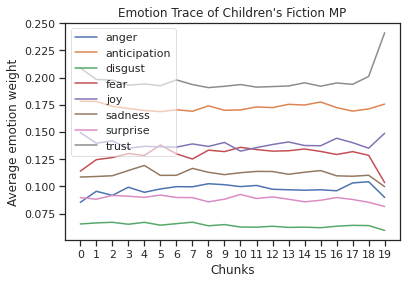

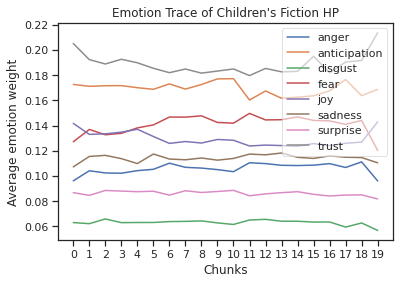

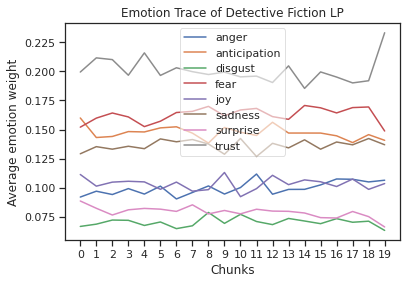

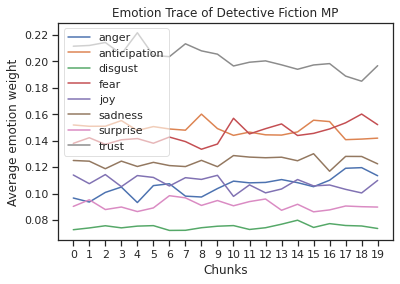

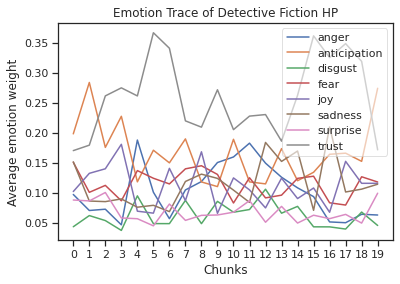

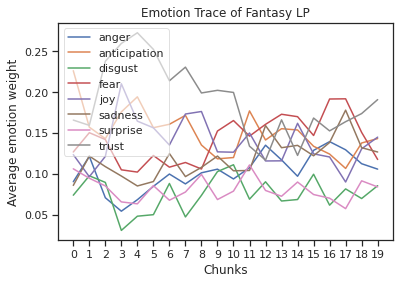

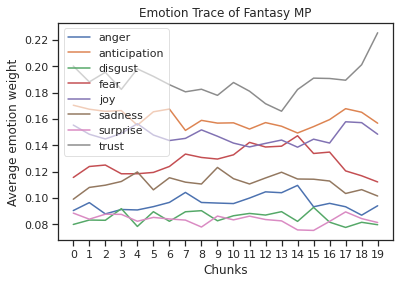

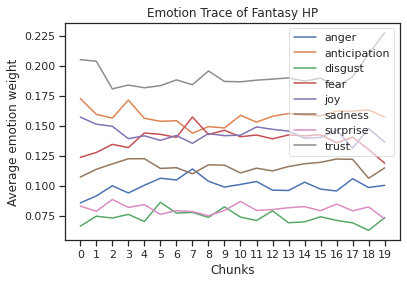

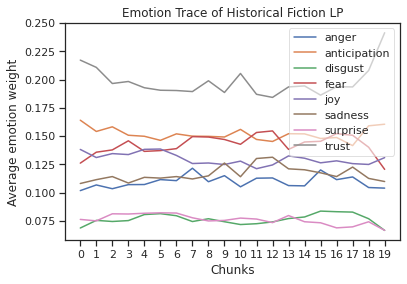

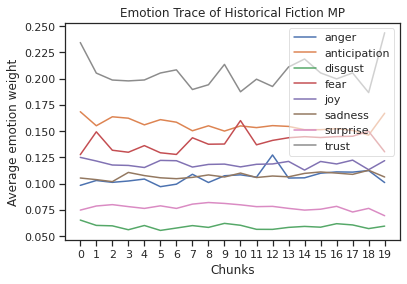

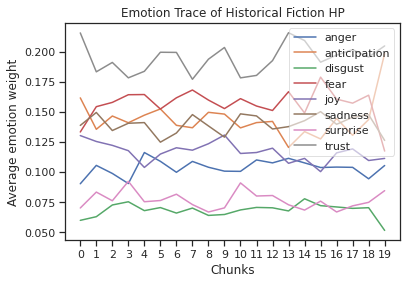

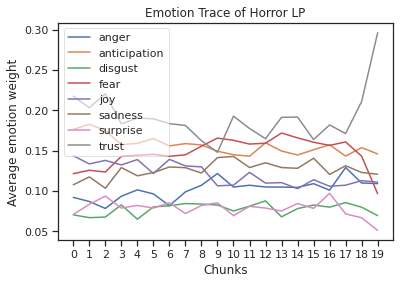

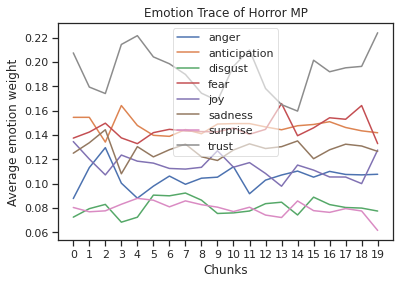

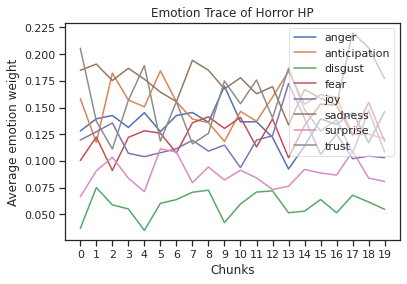

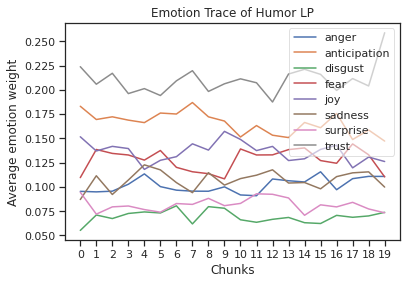

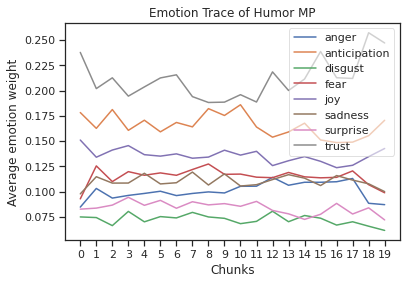

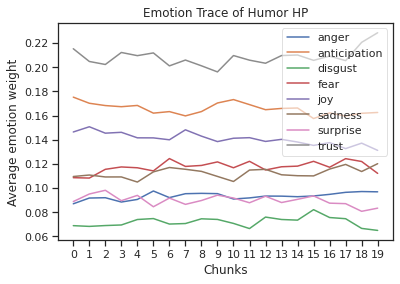

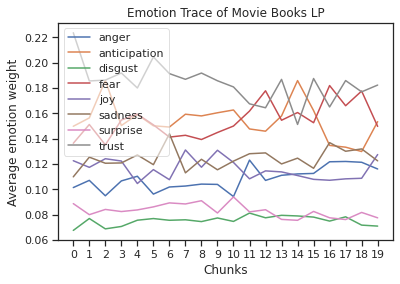

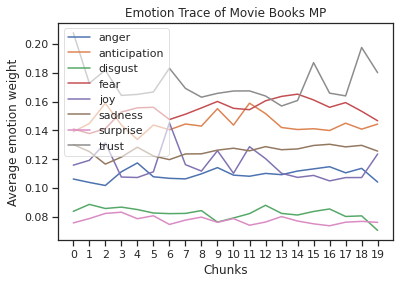

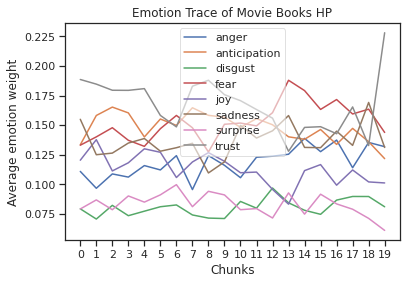

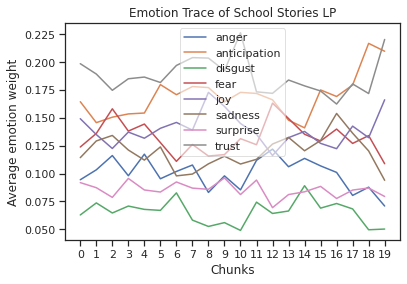

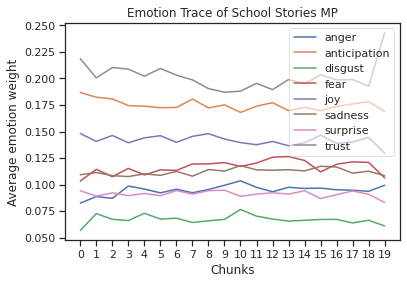

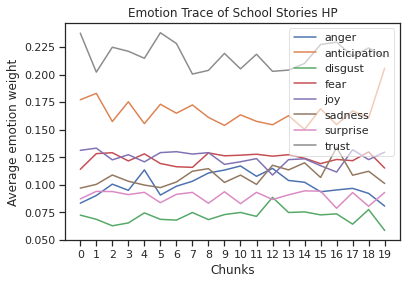

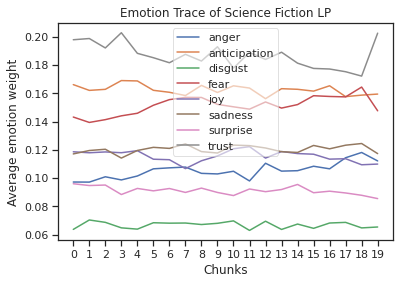

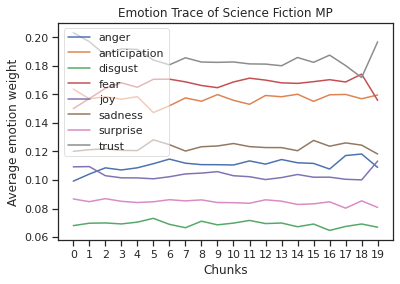

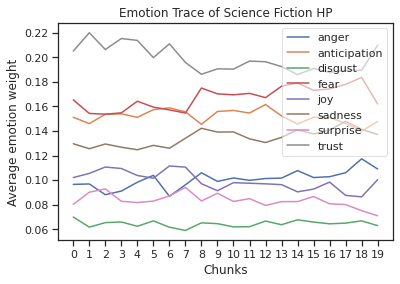

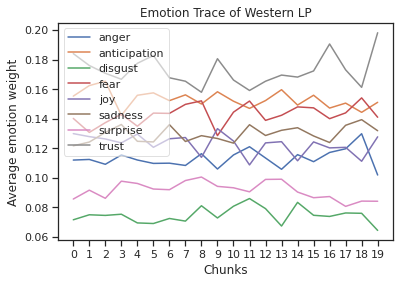

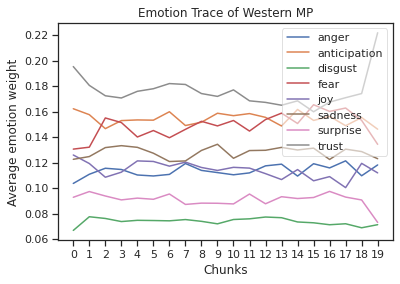

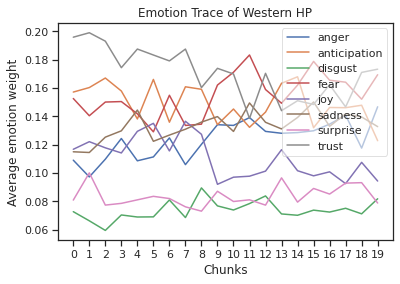

In [103]:
# Select one genre
stddev_dict = {"Children's Fiction": list(), 'Detective Fiction': list(), 'Fantasy': list(),
               'Historical Fiction': list(), 'Horror': list(), 'Humor': list(), 
               'Movie Books': list(), 'School Stories': list(), 'Science Fiction': list(), 'Western': list()}
for G in stddev_dict.keys():
    emo_20 = emo_20_df.loc[emo_20_df['genre'] == G]
    emo_20_rating = emo_20.drop(['title', 'genre', 'rating_count'], axis=1)

    bins = [0, 2, 4, 5]
    rating_level_df = emo_20_rating.groupby(pd.cut(emo_20_rating['rating'], 3, labels=['LP', 'MP', 'HP'])).mean().drop(['rating'], axis=1)

    for g in ['LP', 'MP', 'HP']:
        visual_df = gen_fig_df(rating_level_df, g)
        dev_one_emotion = np.mean(visual_df.std(axis=0))
        dev_emo_dist = np.mean(visual_df.std(axis=1))
        stddev_dict[G].append({g: [dev_one_emotion, dev_emo_dist]})
        draw_et(visual_df, G + ' ' + g)

In [104]:
stddev_dict

{"Children's Fiction": [{'LP': [0.02117911726676254, 0.051245615006945355]},
  {'MP': [0.004952250001582143, 0.04444327343312251]},
  {'HP': [0.004710049761342917, 0.041898641381644716]}],
 'Detective Fiction': [{'LP': [0.005791471528305141, 0.04494615682513897]},
  {'MP': [0.005379565030104412, 0.040547988535259975]},
  {'HP': [0.03687778474178462, 0.07350111005025041]}],
 'Fantasy': [{'LP': [0.026577654496192163, 0.045568044950762374]},
  {'MP': [0.006907213907519473, 0.038484120348570613]},
  {'HP': [0.00668051407155973, 0.04081045493568384]}],
 'Historical Fiction': [{'LP': [0.006760330155400915, 0.04086454035700406]},
  {'MP': [0.005881099039189924, 0.04620373114824161]},
  {'HP': [0.00948710520462629, 0.04326983237233713]}],
 'Horror': [{'LP': [0.014228751164055637, 0.04154762902559346]},
  {'MP': [0.009097781122019668, 0.03878298925733569]},
  {'HP': [0.01810414078706756, 0.041031471123272475]}],
 'Humor': [{'LP': [0.009786294886733373, 0.04704390758693821]},
  {'MP': [0.0089353